# 0. Import & Init

In [1]:
import cv2
import os
import numpy as np
import torch
import torchvision
from networkx import neighbors
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
from glob import glob
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = fasterrcnn_resnet50_fpn(pretrained=True).to(device).eval()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

e:\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# 1. Build Dataset

## 1.1 Extract Frames

In [ ]:
def extract_frames_from_video(video_path, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_path = os.path.join(save_dir, f"{str(frame_idx).zfill(5)}.jpg")
        cv2.imwrite(frame_path, frame)
        frame_idx += 1
    cap.release()
    print(f"Extracted {frame_idx} frames from {video_path} to {save_dir}")


## 1.2 Detect Objects

In [6]:
def detect_and_save_boxes(video_id, data_root='./videos', save_dir='./boxes', threshold=0.5):
    try:
        data_dir = os.path.join(data_root, str(video_id).zfill(3))
        if not os.path.exists(data_dir):
            raise FileNotFoundError(f"视频帧目录 {data_dir} 不存在")
            
        imgs = sorted(glob(os.path.join(data_dir, '*.jpg')))
        if len(imgs) == 0:
            print(f"警告: 目录 {data_dir} 中未找到任何图像")
            return
        
        boxes_seq = []
        progress_bar = tqdm(
            imgs,
            desc = f"处理视频 {str(video_id).zfill(3)}",
            bar_format = "{l_bar}{bar}| {n_fmt}/{total_fmt} [{percentage:3.0f}%]"
        )
        for path in progress_bar:
            try:
                progress_bar.set_postfix(file = os.path.basename(path)[:10])
                
                image = Image.open(path)
                image_tensor = torchvision.transforms.functional.to_tensor(image).to(device)
                output = model([image_tensor])
                scores = output[0]['scores'].cpu().detach().numpy()
                boxes = [
                    box.cpu().detach().numpy()
                    for box, score in zip(output[0]['boxes'], scores)
                    if score > threshold
                ]
                boxes_seq.append(boxes if len(boxes) > 0 else [])
            
            except Exception as e:
                print(f"处理 {path} 时发生错误: {str(e)}")
                boxes_seq.append([])

            finally:
                del image_tensor, output
                torch.cuda.empty_cache()
                
        os.makedirs(save_dir, exist_ok=True)
        np.save(os.path.join(save_dir, f'{video_id}.npy'), np.array(boxes_seq, dtype = object))
        
    except Exception as e:
        print(f"检测与保存失败: {str(e)}")
    finally:
        if 'progress_bar' in locals():
            progress_bar.close()

## 1.3 Visualize Detection

In [26]:
def visualize_detection(video_id, frame_idx, box_dir="./boxes", frame_dir_root="./videos", save_path=None):
    # 加载图像
    frame_dir = os.path.join(frame_dir_root, str(video_id).zfill(3))
    img_path = os.path.join(frame_dir, f"{str(frame_idx).zfill(5)}.jpg")
    image = Image.open(img_path)

    # 加载检测框
    boxes_seq = np.load(os.path.join(box_dir, f"{video_id}.npy"), allow_pickle=True)
    boxes = boxes_seq[frame_idx]

    # 创建一个纯净的画布（无边框、无标题、无坐标轴）
    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])  # 覆盖整个画布
    ax.set_axis_off()  # 彻底关闭坐标轴
    fig.add_axes(ax)
    
    # 显示图像
    ax.imshow(image)
    
    # 绘制检测框
    for box in boxes:
        rect = patches.Rectangle(
            (box[0], box[1]),
            box[2] - box[0],
            box[3] - box[1],
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    # 保存图像（完全无空白）
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=300)
        print(f"✅ 纯净检测结果已保存至: {save_path}")
    
    # 显示预览（可选，带标题）
    plt.close()  # 先关闭纯净画布
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    for box in boxes:
        plt.gca().add_patch(patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=2, edgecolor='red', facecolor='none'))
    plt.title(f"Preview: Video {video_id}, Frame {frame_idx} (保存的图片无标题)")
    plt.axis("off")
    plt.show()

In [28]:
detect_and_save_boxes(video_id=7, threshold=0.5)

处理视频 007: 100%|██████████| 582/582 [100%]


✅ 纯净检测结果已保存至: ./videos/night1.jpg


e:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20445 (\N{CJK UNIFIED IDEOGRAPH-4FDD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23384 (\N{CJK UNIFIED IDEOGRAPH-5B58}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaV

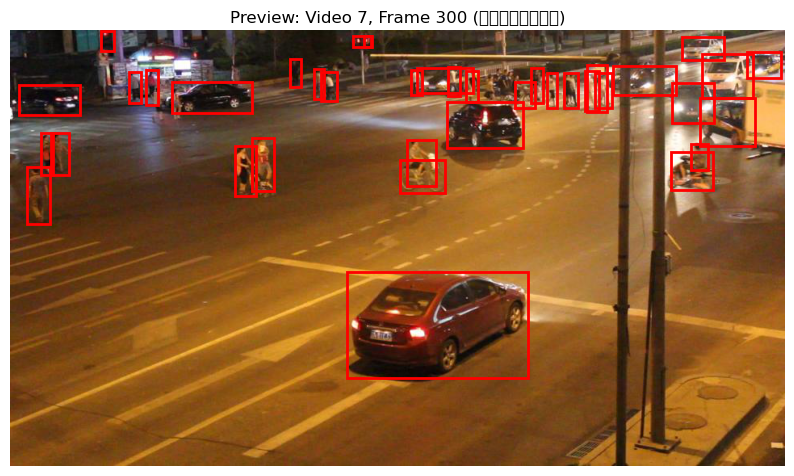

In [30]:
visualize_detection(video_id=7, frame_idx=300, save_path='./videos/night1.jpg')

# 2. Detection Utils

In [9]:
def load_boxes(video_id, box_dir='./boxes'):
    file_path = os.path.join(box_dir, f'{video_id}.npy')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"检测框文件 {file_path} 不存在, 请先运行Build Dataset模块")
    try:
        return np.load(file_path, allow_pickle=True)
    except Exception as e:
        raise ValueError(f"加载文件 {file_path}失败: {str(e)}")

# 3. Tracking

## 3.1 IoU

In [10]:
def cal_iou(box1, box2):
    x_overlap = max(0, min(box1[2], box2[2]) - max(box1[0], box2[0]))
    y_overlap = max(0, min(box1[3], box2[3]) - max(box1[1], box2[1]))
    w_total = max(box1[2], box2[2]) - min(box1[0], box2[0])
    h_total = max(box1[3], box2[3]) - min(box1[1], box2[1])
    return (x_overlap / w_total) * (y_overlap / h_total) if w_total and h_total else 0

## 3.2 Build Box Sequence

In [11]:
def build_box_seq(boxes_seq, idx):
    if len(boxes_seq) == 0:
        return []
    if idx >= len(boxes_seq[0]):
        raise IndexError("初始索引超出第1帧边界框数量")
    last_box = boxes_seq[0][idx]
    box_seq = [last_box]
    for boxes in boxes_seq[1:]:
        if len(boxes) == 0:
            box_seq.append(None)
            continue
        max_iou, cur_box = 0, None
        for box in boxes:
            iou = cal_iou(last_box, box)
            if iou > max_iou:
                max_iou = iou
                cur_box = box
        box_seq.append(cur_box)
        last_box = cur_box if cur_box is not None else last_box
    return box_seq

# 4. Formulation

## 4.1 Compute Motion Distance

In [12]:
def compute_motion_distance(box_seq):
    seq_s = []
    for i in range(len(box_seq) - 1):
        box1 = box_seq[i]
        box2 = box_seq[i + 1]

        if box1 is None or box2 is None:
            seq_s.append(0)
            continue

        c1 = ((box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2)
        c2 = ((box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2)
        s = np.linalg.norm(np.array(c1) - np.array(c2))
        seq_s.append(s)

    return np.array(seq_s)


## 4.2 Detect Anomaly

In [13]:
def detect_anomaly(seq_s, alpha=0.3, k=5):
    if len(seq_s) == 0:
        return []
    if k < 3 or k % 2 == 0:
        raise ValueError("k必须为大于等于3的奇数")
    half_window = k // 2
    res = []
    for i in range(len(seq_s)):
        start = max(0, i - half_window)
        end = min(len(seq_s), i + half_window + 1)
        neighbors = np.concatenate((seq_s[start:i], seq_s[i+1:end]))
        
        if len(neighbors) == 0:
            continue
        avg = np.mean(neighbors)
        if avg == 0:
            continue
            
        if abs(seq_s[i] - avg) > alpha * avg:
            res.append(i)
    return res

# 5. Evaluation

In [14]:
def evaluate_detection(res, ground_truth):
    res_set = set(res)
    gt_set = set(ground_truth)
    TP = len(res_set & gt_set)
    FP = len(res_set - gt_set)
    FN = len(gt_set - res_set)
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    F1 = 2 * precision * recall / (precision + recall)
    return {'TP': TP, 'FP': FP, 'FN': FN, 'precision': precision, 'recall': recall, 'F1': F1}


# 6. Ground Truth Simulation

In [15]:

def simulate_missing_frames(seq_s, ratio=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    seq_s = seq_s.copy()
    n = len(seq_s)
    num_missing = int(np.ceil(n * ratio))
    ground_truth = np.random.permutation(range(1, n - 1))[:num_missing]
    ground_truth = sorted(ground_truth)

    # 合并距离
    for idx in reversed(ground_truth):
        if idx + 1 < len(seq_s):
            seq_s[idx + 1] += seq_s[idx]

    # 删除对应帧
    new_seq_s = [seq_s[i] for i in range(len(seq_s)) if i not in ground_truth]

    return np.array(new_seq_s), ground_truth


# 7. Complet Procedure

In [16]:
def run_full_pipeline_from_frames(video_id, obj_idx=0, gt_ratio=0.1, alpha=0.3, k=5, seed=33):
    #加载检测框+构建伪tracking轨迹
    boxes_seq = load_boxes(video_id)
    box_seq = build_box_seq(boxes_seq, idx=obj_idx)
    #计算帧间运动距离序列
    seq_s = compute_motion_distance(box_seq)
    #模拟gt
    new_seq_s, ground_truth = simulate_missing_frames(seq_s, ratio=gt_ratio, seed=seed)
    #异常检测
    detected = detect_anomaly(new_seq_s, alpha=alpha, k=k)

    eval_result = evaluate_detection(detected, ground_truth)

    print("====== EVALUATION RESULT ======")
    print(f"Ground Truth (丢帧点): {ground_truth}")
    print(f"Detected Anomalies:     {detected}")
    print(f"TP: {eval_result['TP']}, FP: {eval_result['FP']},FN: {eval_result['FN']}")
    print(f"Precision: {eval_result['precision']:.3f}, Recall: {eval_result['recall']:.3f}")
    print(f"F1: {eval_result['F1']:.3f}")

    return eval_result


In [33]:
run_full_pipeline_from_frames(
    video_id=7,
    obj_idx=0,
    gt_ratio=0.1,
    alpha=0.5,
    k=7,
    seed=33
)

====== EVALUATION RESULT ======
Ground Truth (丢帧点): [6, 22, 28, 32, 67, 86, 97, 107, 108, 111, 122, 127, 132, 139, 156, 182, 192, 205, 220, 250, 251, 258, 263, 268, 271, 274, 280, 294, 296, 299, 303, 306, 318, 326, 354, 359, 368, 395, 397, 401, 411, 415, 419, 424, 435, 456, 464, 480, 481, 487, 494, 499, 500, 508, 511, 534, 548, 568, 571]
Detected Anomalies:     [4, 5, 6, 7, 11, 15, 16, 19, 21, 26, 27, 28, 29, 31, 36, 41, 42, 44, 50, 55, 57, 58, 60, 63, 73, 81, 82, 84, 91, 100, 102, 103, 107, 110, 112, 116, 118, 119, 120, 125, 126, 130, 135, 136, 138, 139, 142, 143, 148, 149, 150, 151, 153, 154, 156, 157, 158, 167, 168, 170, 176, 184, 185, 186, 188, 192, 196, 197, 199, 204, 209, 210, 219, 221, 222, 228, 232, 235, 236, 237, 240, 241, 245, 246, 247, 251, 253, 254, 257, 263, 265, 266, 267, 272, 273, 275, 276, 277, 279, 281, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 297, 299, 300, 306, 311, 312, 313, 315, 316, 317, 319, 321, 322, 325, 330, 331, 332, 334, 335, 341, 344, 346, 348

{'TP': 22,
 'FP': 203,
 'FN': 37,
 'precision': 0.09777777777777778,
 'recall': 0.3728813559322034,
 'F1': 0.15492957746478872}